<a href="https://colab.research.google.com/github/bluebluer/hello-wolrd/blob/master/python_pri/cs224_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


Part 1: Count-Based Word Vectors (10 points)

In [3]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

Question 1.1: Implement distinct_words [code] (2 points)

In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus_words = list(set([word for document in corpus for word in document]))
    corpus_words.sort()
    n_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, n_corpus_words

In [6]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [7]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    for index, word in enumerate(words):
        word2ind[word] = index
    M = np.zeros((n_words, n_words))
    for document in corpus:
        document_length = len(document) #文档词的个数
        for i in range(len(document)):#i代表文档中词
            for j in range(max(0, i - window_size), min(document_length, i + window_size + 1)): #滑动窗口
                if not j == i:
                    M[word2ind[document[i]]][word2ind[document[j]]] += 1    
    # ------------------

    return M, word2ind

In [8]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


Question 1.3: Implement reduce_to_k_dim [code] (1 point)

In [8]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [11]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


Question 1.4: Implement plot_embeddings [code] (1 point)

In [11]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    fig = plt.figure()
    plt.style.use('seaborn-whitegrid')
    for word in words:
        x, y = M_reduced[word2ind[word]]
        plt.scatter(x, y, marker = 'x')
        plt.annotate(word, xy = (x, y), xytext = (x, y + 0.05))

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


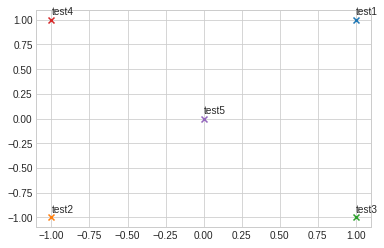

In [13]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Running Truncated SVD over 7146 words...
Done.


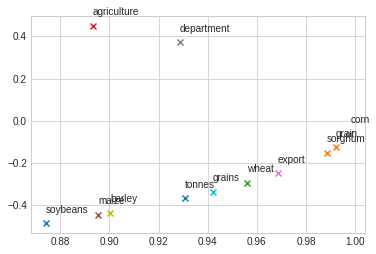

In [14]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

Part 2: Prediction-Based Word Vectors (15 points)


In [1]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index2word)))
    return wv_from_bin

In [3]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


若无法下载，可直接从https://nlp.stanford.edu/projects/glove/ 下载对应词向量文件（以GloVe.6B为例）。
将GloVe.6B.50d.txt复制到指定位置（此处为D:/glove.6B.50d.txt），可实现下面的代码。

In [ ]:
def load_embedding_model():
    from gensim.test.utils import get_tmpfile
    from gensim.scripts.glove2word2vec import glove2word2vec
    glove_file = datapath('D:/glove.6B.50d.txt')
    word2vec_glove_file = get_tmpfile('glove.6B.50d.word2vec.txt')
    glove2word2vec(glove_file, word2vec_glove_file)
    return KeyedVectors.load_word2vec_format(word2vec_glove_file)

Reducing dimensionality of Word Embeddings

In [4]:
def get_matrix_of_vectors(wv_from_bin, required_words=['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    # words = list(wv_from_bin.index_to_key)
    words = list(wv_from_bin.index2word)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [9]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10012 words...
Done.


Question 2.1: GloVe Plot Analysis [written] (3 points)

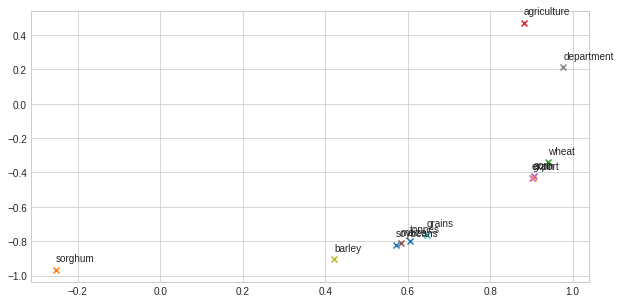

In [17]:
words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']
plot_embeddings(M_reduced_normalized, word2ind, words)

Question 2.2: Words with Multiple Meanings (1.5 points) [code + written]

In [23]:
# ------------------
# Write your implementation here.
wv_from_bin.most_similar('watch')
# ------------------

[('watching', 0.7856484651565552),
 ('watched', 0.6797265410423279),
 ('watches', 0.6186408996582031),
 ('everyone', 0.6093868017196655),
 ("'ll", 0.608327329158783),
 ('you', 0.6075743436813354),
 ('tell', 0.6048123240470886),
 ('sure', 0.5997323989868164),
 ('see', 0.5972887873649597),
 ('know', 0.5910593271255493)]

Question 2.3: Synonyms & Antonyms (2 points) [code + written]

In [27]:
# ------------------
# Write your implementation here.
w1 = 'happy'
w2 = 'cheerful'
w3 = 'sad'
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

Synonyms happy, cheerful have cosine distance: 0.5172466933727264
Antonyms happy, sad have cosine distance: 0.4040136933326721


Question 2.4: Analogies with Word Vectors [written] (1.5 points)

In [28]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608444690704346),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151535749435425),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.6446609497070312),
 ('wife', 0.6445354223251343)]


Question 2.5: Finding Analogies [code + written] (1.5 points)

In [33]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['son','girl'], negative=['boy']))
# ------------------

[('daughter', 0.8898475170135498),
 ('wife', 0.7621181011199951),
 ('father', 0.75502610206604),
 ('niece', 0.7503117322921753),
 ('mother', 0.748228907585144),
 ('eldest', 0.7451066970825195),
 ('daughters', 0.7368088960647583),
 ('husband', 0.7201906442642212),
 ('brother', 0.717461109161377),
 ('married', 0.7169385552406311)]


Question 2.6: Incorrect Analogy [code + written] (1.5 points)

In [35]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['queen','woman'], negative=['king']))
# ------

[('girl', 0.6424112319946289),
 ('she', 0.6289154887199402),
 ('her', 0.6283527612686157),
 ('mother', 0.6221022605895996),
 ('herself', 0.6027998924255371),
 ('wife', 0.5791353583335876),
 ('women', 0.5639066100120544),
 ('lady', 0.5624172687530518),
 ('pregnant', 0.559341549873352),
 ('female', 0.5554540753364563)]


Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

In [37]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['girl', 'toy'], negative=['boy']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['boy', 'toy'], negative=['girl']))

[('toys', 0.7094953060150146),
 ('doll', 0.5932915210723877),
 ('dolls', 0.570662260055542),
 ('barbie', 0.5407705903053284),
 ('mattel', 0.5328551530838013),
 ('accessories', 0.52069091796875),
 ('hasbro', 0.4922722280025482),
 ('jewelry', 0.47385698556900024),
 ('lego', 0.4690813720226288),
 ('apparel', 0.461362361907959)]

[('toys', 0.7157087326049805),
 ('hasbro', 0.5164632797241211),
 ('robot', 0.4731711149215698),
 ('pet', 0.4670490026473999),
 ('manufacturer', 0.46681636571884155),
 ('mattel', 0.4582391381263733),
 ('lego', 0.45811760425567627),
 ('miniature', 0.4441472291946411),
 ('makers', 0.4429824650287628),
 ('manufactured', 0.44275349378585815)]


Question 2.8: Independent Analysis of Bias in Word Vectors [code + written] (1 point)

In [38]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['criminal', 'asian'], negative=['america']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['criminal', 'america'], negative=['asian']))
# ---------

[('crimes', 0.5335632562637329),
 ('prosecution', 0.509348452091217),
 ('malaysian', 0.47679030895233154),
 ('prosecutors', 0.47215837240219116),
 ('suspects', 0.47113656997680664),
 ('alleged', 0.4643544554710388),
 ('offences', 0.4567059874534607),
 ('offenses', 0.4549906551837921),
 ('investigations', 0.4538564085960388),
 ('charges', 0.4523979425430298)]

[('crime', 0.5413945913314819),
 ('justice', 0.5407022833824158),
 ('crimes', 0.5275158882141113),
 ('charges', 0.4853101074695587),
 ('fbi', 0.483420193195343),
 ('law', 0.4822821617126465),
 ('legal', 0.481577605009079),
 ('attorney', 0.48040497303009033),
 ('enforcement', 0.4754365086555481),
 ('criminals', 0.4716635048389435)]


Question 2.9: Thinking About Bias [written] (2 points